In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv",
                 encoding='latin-1',
                 header=None,
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'])

df['target'] = df['target'].replace(4, 1)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\S+|[^a-z\s]', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words or w == 'not']
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import re
df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['target']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Accuracy: 0.77796875
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159494
           1       0.77      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



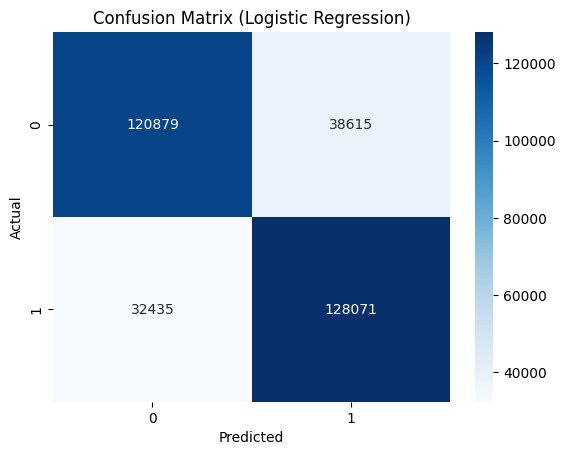

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
import joblib

joblib.dump(model_lr, 'sentiment_lr_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

model_lr = joblib.load('sentiment_lr_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')


In [ ]:
def predict_sentiment(text):
    clean_text = preprocess_text(text)
    features = tfidf.transform([clean_text])
    pred = model_lr.predict(features)
    return 'Positive' if pred[0] == 1 else 'Negative'

print(predict_sentiment("I love this product!"))
print(predict_sentiment("This is the worst experience ever."))


Positive
Negative


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=100)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)

model_lstm = Sequential([
    Embedding(5000, 128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.fit(X_train_lstm, y_train_lstm, epochs=3, batch_size=32, validation_split=0.2)

loss, acc = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f"LSTM Accuracy: {acc}")

model_lstm.save('sentiment_lstm_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 6777s 212ms/step - accuracy: 0.7681 - loss: 0.4783 - val_accuracy: 0.7938 - val_loss: 0.4392
Epoch 2/3
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 6868s 215ms/step - accuracy: 0.7973 - loss: 0.4329 - val_accuracy: 0.7970 - val_loss: 0.4333
Epoch 3/3
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 7068s 219ms/step - accuracy: 0.8035 - loss: 0.4230 - val_accuracy: 0.7983 - val_loss: 0.4329
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 447s 45ms/step - accuracy: 0.7986 - loss: 0.4326


LSTM Accuracy: 0.798453152179718


In [2]:
def predict_sentiment_lstm(text):
    clean_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    pad = pad_sequences(seq, malenn=100)
    pred = model_lstm.predict(pad)
    return 'Positive' if pred[0][0] > 0.5 else 'Negative'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)


True

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/sentiment_lr_model.pkl')

with open('/content/drive/MyDrive/Colab Notebooks/tfidf_vectorizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)


ValueError: File format not supported: filepath=/content/drive/MyDrive/Colab Notebooks/sentiment_lr_model.pkl. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/content/drive/MyDrive/Colab Notebooks/sentiment_lr_model.pkl, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\S+|[^a-z\s]', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words or w in ['not', 'no', 'nor']]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

def predict_sentiment(text):
    clean_text = preprocess_text(text)

    seq = tokenizer.texts_to_sequences([clean_text])
    pad_seq = pad_sequences(seq, maxlen=100)

    prediction = model.predict(pad_seq)
    confidence = prediction[0][0]

    sentiment = 'Positive' if confidence > 0.5 else 'Negative'
    return sentiment, float(confidence)


In [ ]:
if __name__ == "__main__":
    test_samples = [
        "This product exceeded my expectations!",
        "Worst customer service I've ever experienced.",
        "The movie was not bad actually"
    ]

    for text in test_samples:
        sentiment, confidence = predict_sentiment(text)
        print(f"Text: '{text}'\nSentiment: {sentiment} (Confidence: {confidence:.4f})\n")
